In [1]:
import numpy as np 
import scipy
print(np.__version__)
print(scipy.__version__)
import tqdm
import pandas as pd
import exoplanet
import astropy 
import pymc3
import pymc3_ext
import celerite2
from numpy.linalg import inv, det, solve

import matplotlib.pyplot as plt

1.21.0
1.7.3


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def partial_mu(t, theta, wrt):
    """
    Unpack parameters and calculate all partial derivatives of the model w.r.t. those parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - wrt: parameter with respect to which the model's partial derivative is taken
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - derivative vector of length N
    """

    # unpack parameters
    K, P, T0 = theta[0], theta[1], theta[2]
    
    # calculate partial derivative depending on 'wrt'
    normalized_t = t-T0
    arg = (2*np.pi/P) * normalized_t
    
    if wrt=='K':
        return -np.sin(arg)
    elif wrt=='P':
        return -K * np.cos(arg) * arg/P
    elif wrt=='T0':
        return (2*np.pi*K/P) * np.cos(arg)
    
    print("parameter not recognized")
    
    return                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

def calculate_fim(t, sigma, theta):
    """
    Calculate the generalized Fisher Information Matrix according to I_m,n in 
    https://en.wikipedia.org/wiki/Fisher_information#Multivariate_normal_distribution
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - Fisher Information Matrix: len(theta)xlen(theta) matrix; np.array
    
    """
    
    factor2 = np.diag(np.ones(len(sigma))) * sigma**2
    factor2 = np.linalg.solve(factor2, np.identity(len(sigma)))
    
    fim = np.zeros((len(theta),len(theta)))
    for i in range(len(theta)):
        for j in range(len(theta)):
            wrt_i = param_list[i]
            wrt_j = param_list[j]
            
            factor1 = partial_mu(t, theta, wrt_i)#.reshape((1,4)) # partial derivative of the model wrt row parameter, transposed

            factor3 = partial_mu(t, theta, wrt_j)#.reshape((4,1)) # partial derivative of the model wrt column parameter

            fim[i][j] = factor1 @ factor2 @ factor3 # matrix math magic; thanks to Arvind Gupta for the wisdom
    
    return fim

In [3]:
### priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days

test_theta = [test_K, test_P, test_T0]

def make_t(n_obs, cadence, start):
    """
    Gemerate observation times given a number of observations and an average cadence (every X nights)
    
    Input: 
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - start: start time [BJD]
    
    Output:
    - observation times: ndarray
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    end = start + n_obs * cadence 
    t = np.linspace(2300, end, n_obs)
    
    # add jitter ~ N(0, 1 hr) to timestamps
    t += np.random.normal(0, 1./24)

    return t

def strategy(start, n_obs, cadence, theta, sigma_val=None):
    """
    Allows user to try different n_obs and cadences and visualize how that affects the expected RV semi-amplitude uncertainty, sigma_K
    
    Input: 
    - start: start time from which I build out n_obs * cadence
    - n_obs: number of observations to try
    - cadence: amount of time between observations [days]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    - sigma_val: RV measurement uncertainties associated with each observation; float64 [cm/s]
    - sigma_val: covariance matrix; np.array of float64 [cm/s]
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]
    
    Output:
    - sigma_ks: array of sigma_k's calculated by np.linalg.inv [cm/s]
    - sigma_ks_stable: array of sigma_k's calculated by 1/np.sqrt(FIM[0][0])
    
    """
    
    ### make a t using n_obs and cadence
    # initial obs time of 2300 is a placeholder that's set as somewhat close to the arbitrary test_T0 of 2360
    t = make_t(n_obs, cadence, start)
    #print("time steps: ", t)
    
    ### make covariance matrix in the scalar, white noise case
    if sigma_val != None:
        sigma_val += 1e-6 # perturb sigma_val to guard against numerical instabilities
        sigma = np.diag(np.ones(len(t))*sigma_val) # cm/s
        
        fim = calculate_fim(t, sigma, theta)
        #print("FIM: ", fim)
        #print("det: ", det(fim))
        inv_fim = inv(fim)
        #print("inv: ", inv_fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
        #print("sigma_K, using inv: ", sigma_k)
        #sigma_ks.append(sigma_k)
        sigma_k_stable = np.sqrt(1/fim[0][0])
        #print("sigma_K, not using inv: ", sigma_k_stable)

        # np.linalg.solve is more stable than np.linalg.inv, apparently
        inv_fim_solve = solve(fim, np.diag(np.ones(len(theta)))) 
        sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]
        
        return sigma_k, sigma_k_stable, sigma_k_solve, fim
    
    ### make covariance matrix in the correlated noise case
    else:
        sigma = cov_matrix(t, params)
        sigma += 1e-6 
        
        fim = calculate_fim(t, sigma, theta)
        inv_fim = inv(fim)
        sigma_k = np.sqrt(inv_fim)[0][0]
    
        return sigma_k, fim

print(strategy(start=2352, n_obs=100, cadence=1, theta=test_theta, sigma_val=30)) # default to 2300


(4.250128573477437, 4.249908423975684, 4.250128573477437, array([[ 5.53657077e-02,  6.04015053e-01, -1.58113395e-01],
       [ 6.04015053e-01,  1.21877900e+05, -8.48973282e+03],
       [-1.58113395e-01, -8.48973282e+03,  5.50185005e+03]]))


/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


In [4]:
def model(t, theta): 
    """
    Radial velocity model, given timestamps and planetary orbital parameters
    
    Inputs: 
    - t: time series of length N observations; np.array [day]
    - sigma: RV measurement uncertainties associated with each observation; np.array of length N [cm/s]
    - theta: planet orbital parameters; eg. [K, P, T0]; np.array
    
    theta breakdown:
    - K: RV semi-amplitude [cm/s]
    - P: planet period [days]
    - T0: mean transit time [day]

    """
    
    K, P, T0 = theta[0], theta[1], theta[2]
    arg = (2*np.pi/P)*(t-T0)
    rv = -K * np.sin(arg)
    
    return rv

In [5]:
# arbitrary row, yellow streak column
cadence = 3.6
n_obs = 13

print(strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)) # default to 2300



(11.695375357107805, 11.65634915037463, 11.695375357107805, array([[7.35995069e-03, 6.38997248e-01, 1.08255691e-01],
       [6.38997248e-01, 1.22071438e+04, 2.74702943e+03],
       [1.08255691e-01, 2.74702943e+03, 6.99211412e+02]]))


/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[7.40767750e-03 6.97860454e-01 1.00979948e-01]
 [6.97860454e-01 1.20946035e+04 2.72486640e+03]
 [1.00979948e-01 2.72486640e+03 6.94500965e+02]]
sigma_k using linalg.inv:  11.68160468409757
sigma_k using linalg.solve:  11.68160468409757
sigma_k using 1/sqrt(FIM_ii):  11.61873821300393


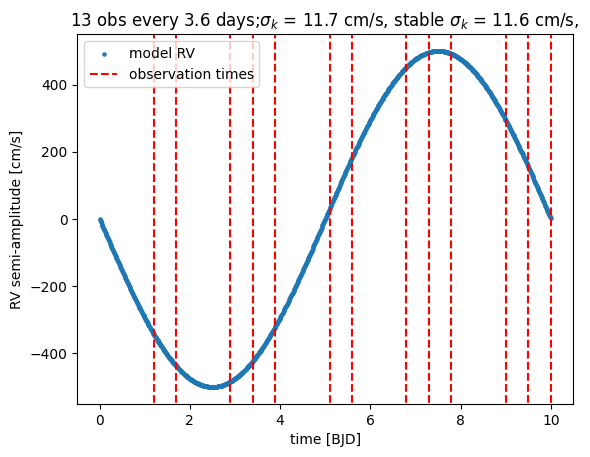

In [7]:
### strategy
cadence = 3.6
n_obs = 13

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/good-strategy-rv.pdf', format='pdf')
plt.legend()
plt.show()

/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 3.88853411e-02 -5.83918441e-01  8.00452927e-03]
 [-5.83918441e-01  4.62988937e+04  1.00974491e+03]
 [ 8.00452927e-03  1.00974491e+03  3.94819139e+03]]
sigma_k using linalg.inv:  5.07164426882244
sigma_k using linalg.solve:  5.07164426882244
sigma_k using 1/sqrt(FIM_ii):  5.07115685198986


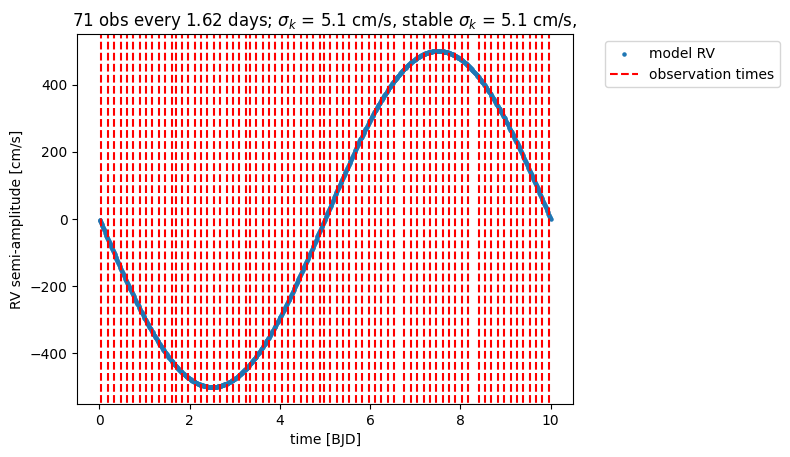

In [9]:
### strategy
cadence = 1.62
n_obs = 71

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/good-strategy-rv.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 4.05753424e-02 -6.08858230e-01 -1.07854178e-02]
 [-6.08858230e-01  4.79766983e+04  6.64953106e+02]
 [-1.07854178e-02  6.64953106e+02  4.00071948e+03]]
sigma_k using linalg.inv:  4.964897264322052
sigma_k using linalg.solve:  4.964897264322052
sigma_k using 1/sqrt(FIM_ii):  4.964424419865652


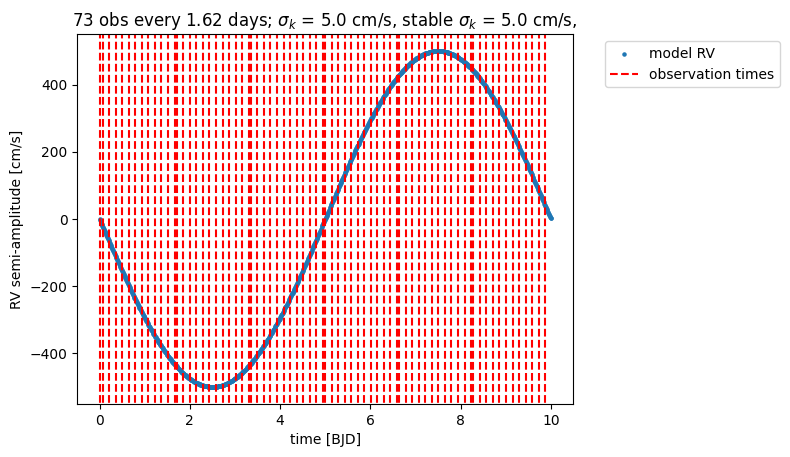

In [17]:
### strategy
cadence = 1.62
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/good-strategy-rv.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


FIM:  [[ 8.70346400e-05 -1.32896584e+01  6.56132754e-01]
 [-1.32896584e+01  2.03544501e+06 -9.58403941e+04]
 [ 6.56132754e-01 -9.58403941e+04  7.99675528e+03]]
sigma_k using linalg.inv:  362545.26750182995
sigma_k using linalg.solve:  362545.26750182995
sigma_k using 1/sqrt(FIM_ii):  107.18991621932076


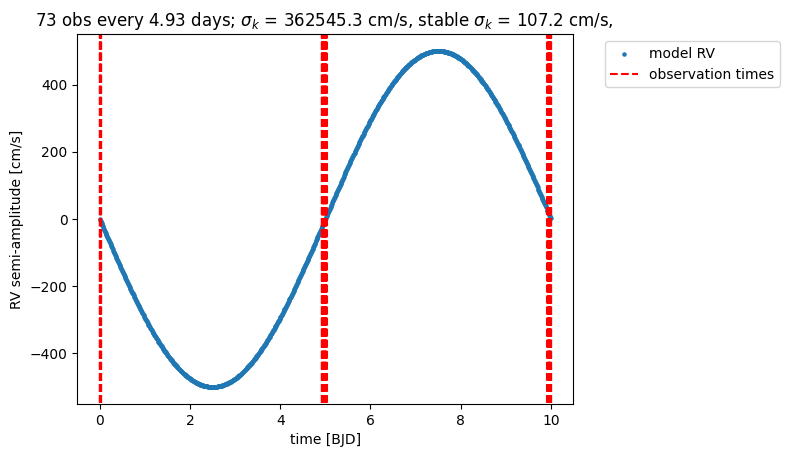

In [18]:
### strategy
cadence = 4.93
n_obs = 73

sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=n_obs, cadence=cadence, theta=test_theta, sigma_val=30)
print("FIM: ", fim)
print("sigma_k using linalg.inv: ", sigma_k)
print("sigma_k using linalg.solve: ", sigma_k_solve)
print("sigma_k using 1/sqrt(FIM_ii): ", sigma_k_stable)
      
### RV model
start = 2300 # BJD
end = 2400 # BJD
test_t = np.linspace(start, end, 1000) + np.random.normal(0, 1./24)
test_t_phase_folded = test_t % test_P
sigma_val = 30+1e-6 # cm/s
test_sigma = np.ones(len(test_t))*sigma_val
y = model(test_t, test_theta)
y_phase_folded = model(test_t_phase_folded, test_theta)

### plot observations from strategy
end = start + cadence * n_obs
strat = np.linspace(2300, end, n_obs) + np.random.normal(0, 1./24)
strat_phase_folded = strat % test_P

plt.scatter(test_t_phase_folded, y_phase_folded, s=5, label='model RV')
plt.axvline(0, 0, 0, linestyle='--', c='r', label='observation times')
for i in strat_phase_folded:
    plt.axvline(i, min(y_phase_folded), max(y_phase_folded), linestyle='--', c='r')
plt.xlabel('time [BJD]')
plt.ylabel('RV semi-amplitude [cm/s]')
plt.title(f'{n_obs} obs every {cadence} days; ' + r'${\sigma}_k$' + f' = {np.round(sigma_k, 1)} cm/s, ' + r'stable ${\sigma}_k$' + f' = {np.round(sigma_k_stable, 1)} cm/s, ')
#plt.savefig('plots/good-strategy-rv.pdf', format='pdf')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

Let's explore the full parameter space of (n_obs, cadence), so that we can plot sensitivity maps

In [12]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)
sigma_ks = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

#with tqdm.tqdm(total=100) as pbar:
for enum_i, i in enumerate(n_observations):
    for enum_j, j in enumerate(cadences):
        #print(i, j)
        sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=2300, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)

        sigma_ks[enum_i][enum_j] = sigma_k
        sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
        sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


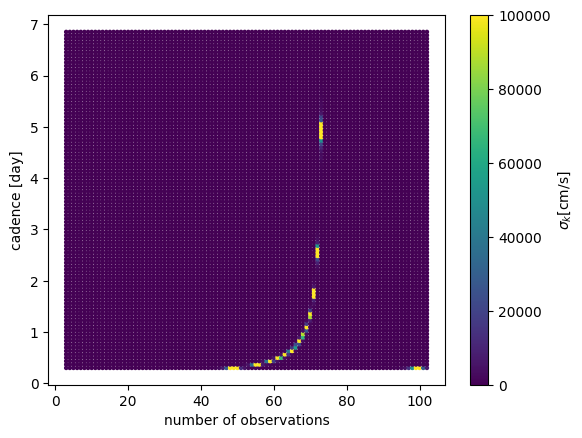

In [13]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks, s=5, vmin=0, vmax=100000)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

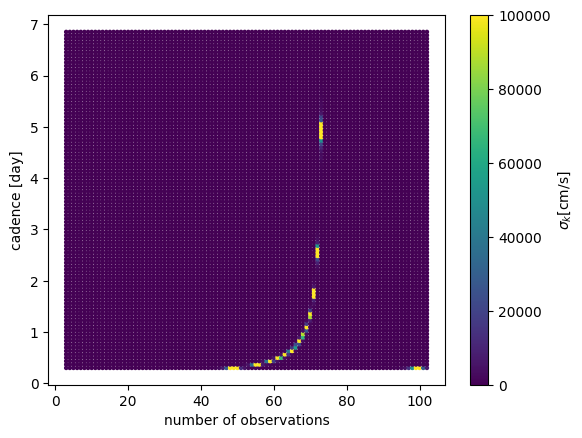

In [14]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve, s=5, vmin=0, vmax=100000)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

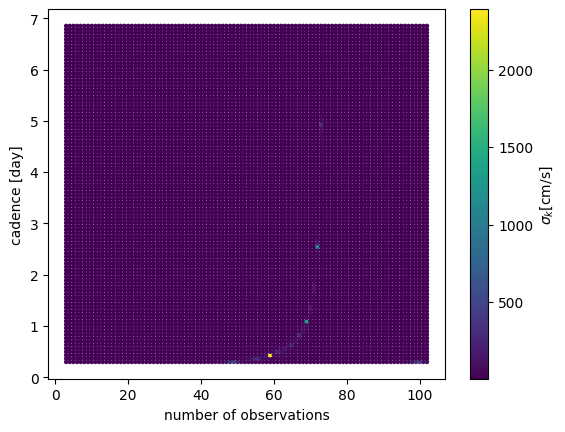

In [15]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable, s=5)#, vmin=0, vmax=100000)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
#plt.savefig("plots/n_obs-cadence-sigma_k.pdf", format="pdf")
plt.show()

Let's marginalize over different starts time to get a more smoothed picture

In [16]:
# priors
param_list = ['K','P','T0']
test_T0 = 2360 # BJD
test_K = 500 # 5 m/s to 500 cm/s; it worked for 10000 cm/s
test_P = 10 # days
test_theta = [test_K, test_P, test_T0]

dim = 100

### try different numbers of total observations made
n_observations = np.linspace(3, 102, dim).astype(int)

### try different observing cadences
### lower bound
# Arjun Savel (thanks, Arjun!) says that 0.6 days is generally considered the minimum (why?)
# Nyquist sampling says halve that to 0.3 days
# Nyquist sampling says the minimum number of observations you need to confirm periodicity is 2
# See wikipedia page for 'Nyquist rate'

### upper bound
# TESS planets generally have max period of 13.7 days
# again, due to Nyquist, halve it to 6.85 days
cadences = np.linspace(0.30, 6.85, dim)

#with tqdm.tqdm(total=100) as pbar:
starts = np.linspace(2300, 2300+test_P, 200)
sigma_ks_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_stable_all = np.ones(dim**2).reshape((dim,dim))
sigma_ks_solve_all = np.ones(dim**2).reshape((dim,dim))
    
for start in starts: 
    sigma_ks = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_stable = np.ones(dim**2).reshape((dim,dim))
    sigma_ks_solve = np.ones(dim**2).reshape((dim,dim))

    for enum_i, i in enumerate(n_observations):
        for enum_j, j in enumerate(cadences):
            try:
                sigma_k, sigma_k_stable, sigma_k_solve, fim = strategy(start=start, n_obs=i, cadence=j, theta=test_theta, sigma_val=30)
            except Exception as e:
                print(e, ", culprit: ", start, i, j)

            sigma_ks[enum_i][enum_j] = sigma_k
            sigma_ks_stable[enum_i][enum_j] = sigma_k_stable
            sigma_ks_solve[enum_i][enum_j] = sigma_k_solve

            sigma_ks_all += sigma_ks
            sigma_ks_stable_all += sigma_ks_stable
            sigma_ks_solve_all += sigma_ks_solve

/tmp/ipykernel_152620/2741385182.py:71: RuntimeWarning: invalid value encountered in sqrt
  sigma_k = np.sqrt(inv_fim)[0][0]
/tmp/ipykernel_152620/2741385182.py:79: RuntimeWarning: invalid value encountered in sqrt
  sigma_k_solve = np.sqrt(inv_fim_solve)[0][0]


Singular matrix , culprit:  2302.8643216080404 4 6.783838383838384
Singular matrix , culprit:  2304.572864321608 18 4.468181818181818
Singular matrix , culprit:  2309.2964824120604 6 6.783838383838384


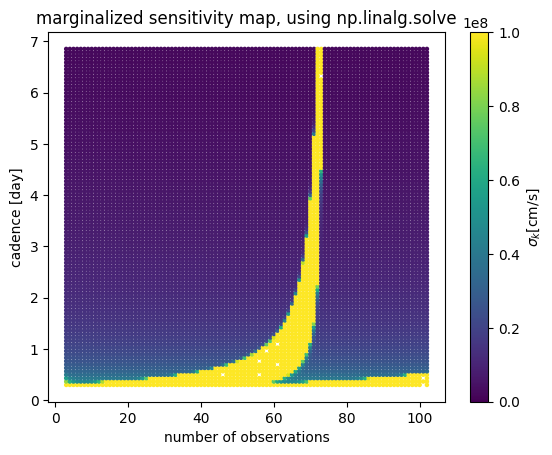

In [21]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_solve_all, s=5, vmin=0, vmax=1e8)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.solve")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

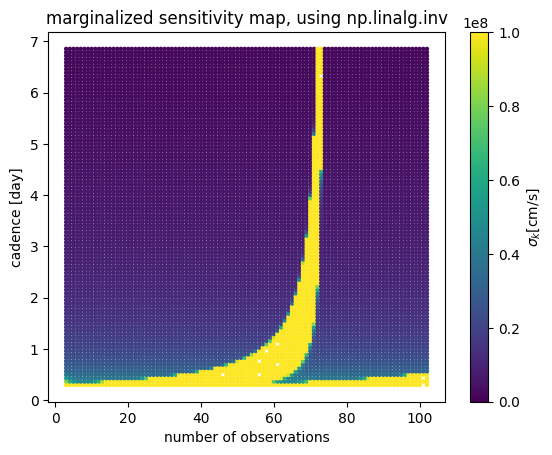

In [22]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_all, s=5, vmin=0, vmax=1e8)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using np.linalg.inv")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()

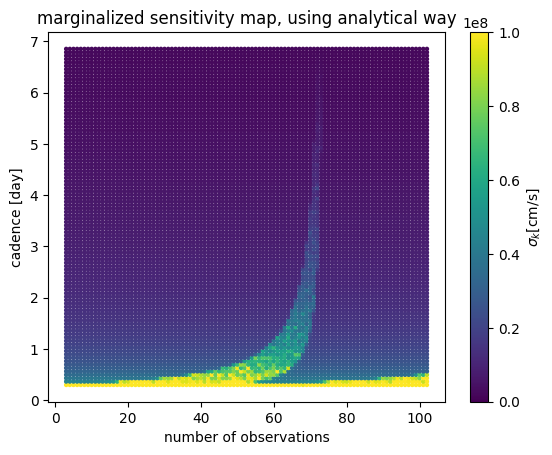

In [23]:
x, y = np.meshgrid(n_observations, cadences)
plt.scatter(x, y, c=sigma_ks_stable_all, s=5, vmin=0, vmax=1e8)
cbar = plt.colorbar()
cbar.ax.set_ylabel(r"$\sigma_k$[cm/s]")
plt.title("marginalized sensitivity map, using analytical way")
plt.xlabel("number of observations")
plt.ylabel("cadence [day]")
plt.show()